In [91]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
echo "Running evaluation sweep for unstructured sparse architecture"
time python sweep.py unstructured

Running evaluation sweep for unstructured sparse architecture
=== Mode: unstructured ===
Arch: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core.yaml
Dataflow: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/unstructured_dataflow.yaml
SparseOpt: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml
ERT: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT.yaml
ART: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml
Mapper: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml

--- resnet50_conv1 (unstructured) ---
--- Stage 1: Mapping Search ---
Running command: timeloop-mapper /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/_tmp_unstructured_resnet50_conv1/aggregat

[  0] Utilization = 0.25 | pJ/Compute =    4.506 | L3[WIO] M2 Q8 P4 - L2[WI] P7 C3 S7 P4X - L1[O] R7 Q14 M16X - L0[I] M2 
[  0] Utilization = 0.50 | pJ/Compute =   12.767 | L3[WIO] P14 Q7 - L2[] S7 Q2X - L1[O] Q2 P2 R7 C3 P4X M16X - L0[I] Q4 M4 
[  0] Utilization = 0.50 | pJ/Compute =    5.331 | L3[WIO] P14 Q7 - L2[W] S7 Q2X - L1[O] Q2 P2 R7 C3 P4X M16X - L0[I] Q4 M4 
[  0] Utilization = 0.50 | pJ/Compute =    3.821 | L3[WIO] P14 Q7 - L2[WI] S7 Q2X - L1[O] Q2 P2 R7 C3 P4X M16X - L0[I] Q4 M4 
[  0] Utilization = 0.50 | pJ/Compute =    3.807 | L3[WIO] Q7 P14 - L2[WI] S7 Q2X - L1[O] P2 Q2 R7 C3 P4X M16X - L0[I] Q4 M4 
[  0] STATEMENT: 2000 invalid mappings (2000 fanout, 0 capacity) found since the last valid mapping, terminating search.

Results in /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/unstructured_resnet50_conv1
--- alexnet_conv1 (unstructured) ---
--- Stage 1: Mapping Search ---
Running command: timeloop-mapper /home/workspace/2022.micro.

Mapspace Dimension [LoopPermutation] Size: 6096384000
Mapspace Dimension [Spatial] Size: 64
Mapspace Dimension [DatatypeBypass] Size: 8
Mapspace split! Per-split Mapping Dimension [IndexFactorization] Size: 648000 Residue: 0
Mapspace construction complete.
Search configuration complete.


Summary stats for best mapping found by mapper:
  Utilization = 0.16 | pJ/Compute =    6.775

Timeloop stderr:
[  1] Utilization = 0.12 | pJ/Compute =   67.399 | L3[WIO] Q1 - L2[] P5 Q11 M2X - L1[O] S11 Q5 P11 R11 M16X - L0[I] M3 C3 
[  0] Utilization = 0.06 | pJ/Compute =   67.358 | L3[WIO] Q1 - L2[] Q11 P5 C3 - L1[O] S11 R11 Q5 P11 M16X - L0[I] M6 
[  3] Utilization = 0.12 | pJ/Compute =   67.399 | L3[WIO] Q1 - L2[] P5 Q11 M2X - L1[O] R11 P11 S11 C3 Q5 M16X - L0[I] M3 
[  2] Utilization = 0.12 | pJ/Compute =   66.288 | L3[WIO] Q1 - L2[] Q11 P5 M2X - L1[O] P11 S11 R11 Q5 C3X M16X - L0[I] M3 
[  1] Utilization = 0.12 | pJ/Compute =    7.886 | L3[WIO] Q1 - L2[W] P5 Q11 M2X - L1[O] S11 Q5 P11 R11 M16X -

[  0] Utilization = 0.25 | pJ/Compute =    7.488 | L3[WIO] Q8 P4 - L2[WI] P7 M2 S3 P4X - L1[O] R3 Q14 C3 M16X - L0[I] Q1 
[  0] Utilization = 0.25 | pJ/Compute =    7.471 | L3[WIO] P4 Q8 - L2[WI] M2 P7 S3 P4X - L1[O] Q14 R3 C3 M16X - L0[I] Q1 
[  0] Utilization = 0.50 | pJ/Compute =   16.560 | L3[WIO] Q7 P14 - L2[] S3 Q2X - L1[O] P2 Q2 R3 P4X M16X - L0[I] Q4 M2 C3 
[  0] Utilization = 0.50 | pJ/Compute =    9.124 | L3[WIO] Q7 P14 - L2[W] S3 Q2X - L1[O] P2 Q2 R3 P4X M16X - L0[I] Q4 M2 C3 
[  0] Utilization = 0.50 | pJ/Compute =    6.860 | L3[WIO] Q7 P14 - L2[WI] S3 Q2X - L1[O] P2 Q2 R3 P4X M16X - L0[I] Q4 M2 C3 
[  3] Utilization = 0.33 | pJ/Compute =   21.884 | L3[WIO] M2 Q2 - L2[W] Q4 C3 P14 R3 P2X - L1[O] P4 Q7 S3X M16X - L0[I] Q2 
[  3] Utilization = 0.33 | pJ/Compute =   12.346 | L3[WIO] Q2 M2 - L2[W] Q4 P14 R3 C3 P2X - L1[O] P4 Q7 S3X M16X - L0[I] Q2 
[  0] STATEMENT: 2000 invalid mappings (2000 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  2] STAT

[  3] STATEMENT: 2000 invalid mappings (2000 fanout, 0 capacity) found since the last valid mapping, terminating search.

Results in /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/unstructured_mobilenet_conv1
Done.



real	0m11.398s
user	0m17.458s
sys	0m0.137s


In [110]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
echo "Running evaluation sweep for structured sparse architecture"
time python sweep.py structured

Running evaluation sweep for structured sparse architecture
=== Mode: structured ===
Arch: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/structured_2_4_tensor_core.yaml
Dataflow: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/structured_2_4_dataflow.yaml
SparseOpt: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/structured_2_4.yaml
ERT: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_structured.yaml
ART: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART_structured.yaml
Mapper: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml

--- resnet50_conv1 (structured) ---
--- Stage 1: Mapping Search ---
Running command: timeloop-mapper /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/_tmp_structured_resnet50_c


Results in /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/structured_resnet50_conv1
--- alexnet_conv1 (structured) ---
--- Stage 1: Mapping Search ---
Running command: timeloop-mapper /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/_tmp_structured_alexnet_conv1/aggregated_inputs.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_structured.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART_structured.yaml -o .
Timeloop stdout:
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (ar

Timeloop stdout:
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using threads = 4
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension C = 5
  Factorization options along problem dimension M = 4
  Factorization options along problem dimension R = 5
  Factorization options along problem dimension S = 5
  Factorization options along problem dimension N = 1
  Factorization options along problem dimension P = 756
  Factorization options along pro

[  0] Utilization = 0.25 | pJ/Compute =    9.013 | L3[WIO] Q8 P4 - L2[WO] M2 S3 P7 P4X - L1[O] C3 R3 Q14 M16Y - L0[I] Q1 
[  2] Utilization = 0.25 | pJ/Compute =   10.133 | L3[WIO] Q8 P4 - L2[WIO] C3 P7 S3 M2 P4X - L1[O] Q14 R3 M16Y - L0[I] Q1 
[  0] Utilization = 0.25 | pJ/Compute =    7.805 | L3[WIO] Q8 P4 - L2[WIO] M2 S3 P7 P4X - L1[O] C3 R3 Q14 M16Y - L0[I] Q1 
[  2] Utilization = 0.25 | pJ/Compute =    7.890 | L3[WIO] P4 Q8 - L2[W] P7 M2 S3 C3 P4X - L1[O] Q14 R3 M16Y - L0[I] Q1 
[  2] Utilization = 0.25 | pJ/Compute =    6.673 | L3[WIO] P4 Q8 - L2[WI] P7 M2 S3 C3 P4X - L1[O] Q14 R3 M16Y - L0[I] Q1 
[  0] Utilization = 0.25 | pJ/Compute =    7.796 | L3[WIO] P4 Q8 - L2[WIO] S3 P7 M2 P4X - L1[O] Q14 C3 R3 M16Y - L0[I] Q1 
[  0] Utilization = 0.25 | pJ/Compute =    6.682 | L3[WIO] Q8 P4 - L2[WI] P7 M2 S3 P4X - L1[O] R3 Q14 C3 M16Y - L0[I] Q1 
[  0] Utilization = 0.25 | pJ/Compute =    6.673 | L3[WIO] P4 Q8 - L2[WI] M2 P7 S3 P4X - L1[O] Q14 R3 C3 M16Y - L0[I] Q1 
[  0] STATEMENT: 2000 


real	0m2.694s
user	0m3.952s
sys	0m0.122s


In [111]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts && \
time ./parse_and_plot.py

Parsing results...

Energy Breakdown by Hardware Level:

Unstructured Architecture:

  ResNet-50 C1:
    L0_MAC: 66,182,224.28 pJ (14.73%)
    L1_LRF: 41,747,951.83 pJ (9.29%)
    L2_RF: 196,782,107.36 pJ (43.80%)
    L3_SMEM: 81,190,180.19 pJ (18.07%)
    L4_DRAM: 63,370,240.00 pJ (14.11%)

  AlexNet C1:
    L0_MAC: 59,116,844.16 pJ (8.28%)
    L1_LRF: 34,588,882.67 pJ (4.84%)
    L2_RF: 58,591,885.18 pJ (8.20%)
    L3_SMEM: 470,777,045.09 pJ (65.92%)
    L4_DRAM: 91,092,992.00 pJ (12.76%)

  MobileNetV1 C1:
    L0_MAC: 6,077,959.37 pJ (8.69%)
    L1_LRF: 4,476,963.78 pJ (6.40%)
    L2_RF: 18,074,611.47 pJ (25.85%)
    L3_SMEM: 5,832,924.54 pJ (8.34%)
    L4_DRAM: 35,465,728.00 pJ (50.72%)

Structured 2:4 Architecture:

  ResNet-50 C1:
    L0_MAC: 52,738,074.87 pJ (8.66%)
    L1_LRF: 2,155,229.80 pJ (0.35%)
    L2_RF: 375,684,587.19 pJ (61.70%)
    L3_SMEM: 140,746,302.21 pJ (23.11%)
    L4_DRAM: 37,598,720.00 pJ (6.17%)

  AlexNet C1:
    L0_MAC: 47,107,944.58 pJ (5.56%)
    L1_LRF: 


real	0m1.482s
user	0m3.082s
sys	0m3.701s


Displaying image: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/figures/sparsity_comparison.png


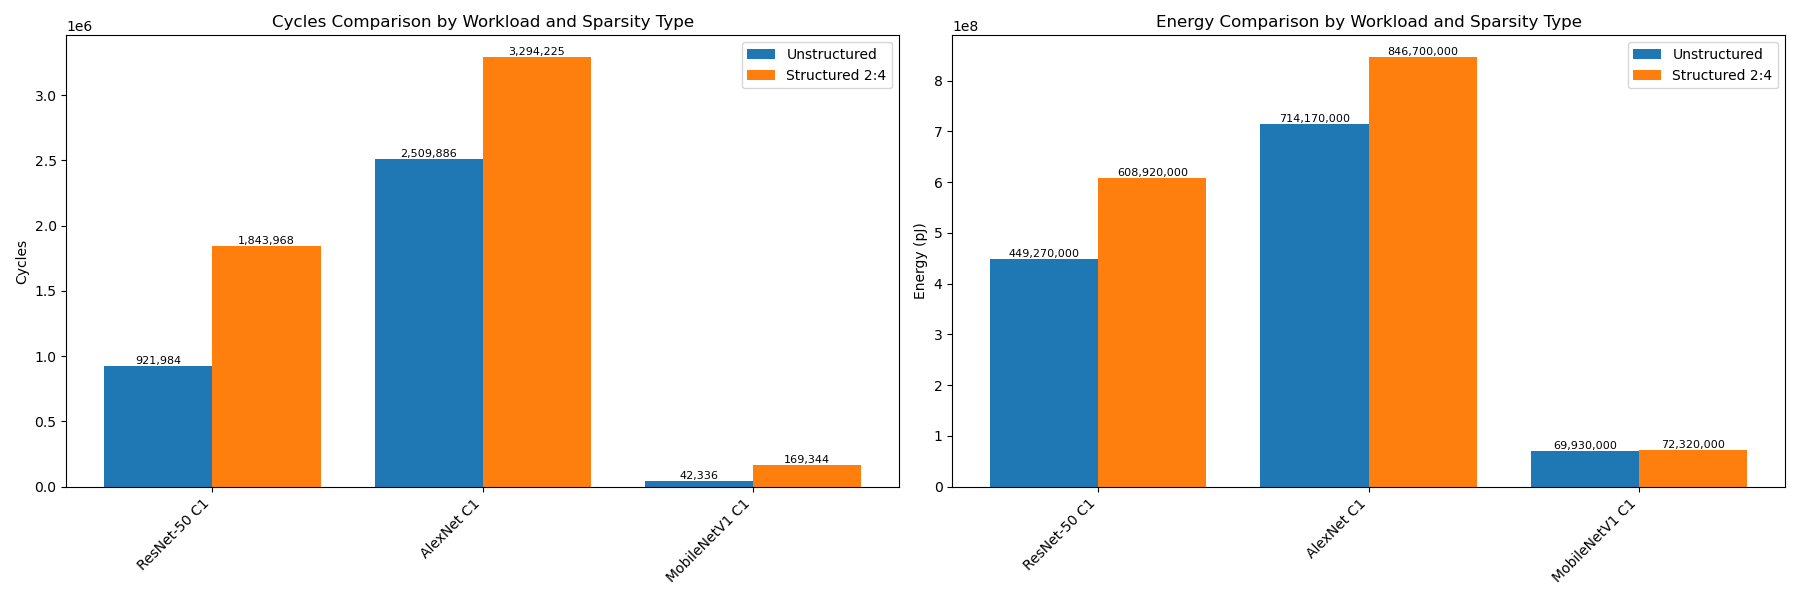

In [112]:
from IPython.display import Image, display
import os

# --- Filename (should match the one saved by the script) ---
image_filename = f"/home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/figures/sparsity_comparison.png"
# ---

# Check if the image file exists before trying to display
if os.path.exists(image_filename):
    print(f"Displaying image: {image_filename}")
    display(Image(filename=image_filename))
else:
    print(f"ERROR: Image file not found at {image_filename}")
    print("Please ensure the comparison script ran successfully.")